Running on Device: cuda


100%|██████████| 170498071/170498071 [00:05<00:00, 31831091.58it/s]


Extracting ./CIFAR10data/cifar-10-python.tar.gz to ./CIFAR10data


/home/knallap/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/knallap/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/40] Loss D: -17.1232, Loss G: 57.8183, FID: 133.7298
Epoch [2/40] Loss D: -15.1486, Loss G: 64.5564, FID: 139.4077
Epoch [3/40] Loss D: -12.8487, Loss G: 62.5517, FID: 136.4626
Epoch [4/40] Loss D: -13.2374, Loss G: 66.5703, FID: 135.4370
Epoch [5/40] Loss D: -13.6402, Loss G: 72.6907, FID: 138.5933
Epoch [6/40] Loss D: -11.3702, Loss G: 80.0429, FID: 138.6389
Epoch [7/40] Loss D: -12.4875, Loss G: 78.9404, FID: 141.4207
Epoch [8/40] Loss D: -15.9689, Loss G: 80.8519, FID: 140.1757
Epoch [9/40] Loss D: -11.3828, Loss G: 83.0334, FID: 138.4927
Epoch [10/40] Loss D: -10.6908, Loss G: 82.1046, FID: 138.9782
Epoch [11/40] Loss D: -14.3220, Loss G: 82.3381, FID: 139.7220
Epoch [12/40] Loss D: -15.4991, Loss G: 88.3652, FID: 137.2323
Epoch [13/40] Loss D: -13.0276, Loss G: 96.8617, FID: 141.5534
Epoch [14/40] Loss D: -12.4281, Loss G: 97.4406, FID: 137.3979
Epoch [15/40] Loss D: -11.3378, Loss G: 104.8632, FID: 140.4128
Epoch [16/40] Loss D: -9.8181, Loss G: 111.7512, FID: 139.5369


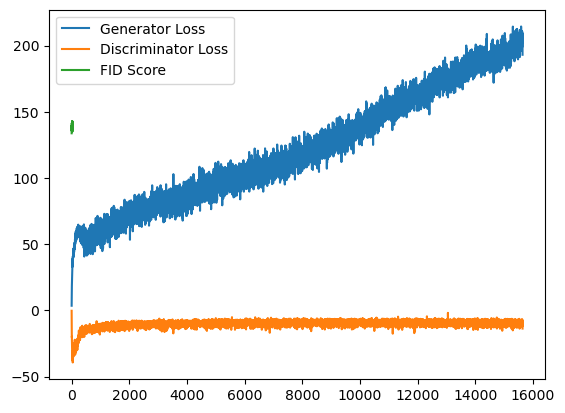

In [1]:
import torch
import torch.nn as nn
import torch.optim as optimizer
import torch.nn.functional as F
import torchvision
import torchvision.datasets as dataset_loader
import torchvision.transforms as transformations
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vision_utils
from scipy import linalg
import torchvision.models as pretrained_models
import os

# Set random seed and device
torch.manual_seed(1)
compute_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Running on Device:', compute_device)

# Training Hyperparameters
LEARN_RATE = 2e-4
BATCH_SIZE = 128
IMG_SIZE = 64
NUM_CHANNELS = 3
LATENT_VECTOR_SIZE = 100
TOTAL_EPOCHS = 40
DISC_FEATURES = 64
GEN_FEATURES = 64
CRITIC_STEPS = 5
GRADIENT_PENALTY = 10

# Dataset and DataLoader
data_transforms = transformations.Compose([
    transformations.Resize(IMG_SIZE),
    transformations.ToTensor(),
    transformations.Normalize([0.5] * 3, [0.5] * 3)
])

image_dataset = dataset_loader.CIFAR10(root="./CIFAR10data", download=True, transform=data_transforms)
data_loader = DataLoader(image_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Results Directory
os.makedirs('Results', exist_ok=True)


# Define Discriminator Model
class Adversary(nn.Module):
    def __init__(self, channels, features):
        super(Adversary, self).__init__()
        self.architecture = nn.Sequential(
            nn.Conv2d(channels, features, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self.disc_block(features, features * 2, 4, 2, 1),
            self.disc_block(features * 2, features * 4, 4, 2, 1),
            self.disc_block(features * 4, features * 8, 4, 2, 1),
            nn.Conv2d(features * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def disc_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.architecture(x)


# Define Generator Model
class ImageGenerator(nn.Module):
    def __init__(self, noise_dim, output_channels, features):
        super(ImageGenerator, self).__init__()
        self.generator_architecture = nn.Sequential(
            self.gen_block(noise_dim, features * 8, 4, 1, 0),
            self.gen_block(features * 8, features * 4, 4, 2, 1),
            self.gen_block(features * 4, features * 2, 4, 2, 1),
            self.gen_block(features * 2, features, 4, 2, 1),
            nn.ConvTranspose2d(features, output_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def gen_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.generator_architecture(x)


# Weight Initialization
def initialize_model_weights(model):
    for layer in model.modules():
        if isinstance(layer, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(layer.weight.data, 0.0, 0.02)


# Gradient Penalty Function
def compute_gradient_penalty(critic_model, real_samples, fake_samples):
    batch_size, channels, height, width = real_samples.size()
    alpha = torch.rand((batch_size, 1, 1, 1)).repeat(1, channels, height, width).to(compute_device)
    interpolated = real_samples * alpha + fake_samples * (1 - alpha)
    interpolated.requires_grad_(True)

    scores = critic_model(interpolated)
    grad_outputs = torch.ones(scores.size()).to(compute_device)

    gradients = torch.autograd.grad(
        outputs=scores,
        inputs=interpolated,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
    )[0]
    gradients = gradients.view(batch_size, -1)
    gradients_norm = gradients.norm(2, dim=1)
    return ((gradients_norm - 1) ** 2).mean()


# FID Calculation Functions
class PretrainedInception(nn.Module):
    def __init__(self, output_blocks=[3]):
        super(PretrainedInception, self).__init__()
        inception = pretrained_models.inception_v3(pretrained=True)
        self.blocks = nn.ModuleList([
            nn.Sequential(inception.Conv2d_1a_3x3, inception.Conv2d_2a_3x3, inception.Conv2d_2b_3x3,
                          nn.MaxPool2d(kernel_size=3, stride=2)),
            nn.Sequential(inception.Conv2d_3b_1x1, inception.Conv2d_4a_3x3, nn.MaxPool2d(kernel_size=3, stride=2)),
            nn.Sequential(inception.Mixed_5b, inception.Mixed_5c, inception.Mixed_5d,
                          inception.Mixed_6a, inception.Mixed_6b, inception.Mixed_6c, inception.Mixed_6d,
                          inception.Mixed_6e),
            nn.Sequential(inception.Mixed_7a, inception.Mixed_7b, inception.Mixed_7c,
                          nn.AdaptiveAvgPool2d(output_size=(1, 1))),
        ])
        self.output_blocks = output_blocks
        self.last_block = max(output_blocks)

    def forward(self, x):
        outputs = []
        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outputs.append(x)
            if idx == self.last_block:
                break
        return outputs[0]


def calculate_fid_statistics(images, model):
    images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
    images = images * 2 - 1  # Normalize to range [-1, 1]
    activations = model(images).view(images.size(0), -1).detach().cpu().numpy()
    mu = np.mean(activations, axis=0)
    sigma = np.cov(activations, rowvar=False)
    return mu, sigma


def compute_fid(mu1, sigma1, mu2, sigma2):
    diff = mu1 - mu2
    cov_mean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real
    return diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * cov_mean)


# Instantiate Models and Optimizers
generator = ImageGenerator(LATENT_VECTOR_SIZE, NUM_CHANNELS, GEN_FEATURES).to(compute_device)
discriminator = Adversary(NUM_CHANNELS, DISC_FEATURES).to(compute_device)
initialize_model_weights(generator)
initialize_model_weights(discriminator)

gen_optimizer = optimizer.RMSprop(generator.parameters(), lr=LEARN_RATE)
disc_optimizer = optimizer.RMSprop(discriminator.parameters(), lr=LEARN_RATE)

fixed_latent_noise = torch.randn(BATCH_SIZE, LATENT_VECTOR_SIZE, 1, 1).to(compute_device)

# Load Pretrained Inception for FID
inception_model = PretrainedInception().to(compute_device)

import torchvision.utils as vision_utils

# Function to save comparison images
def save_comparison_images(real_images, fake_images, epoch, results_dir='Results/Comparison_Images'):
    os.makedirs(results_dir, exist_ok=True)
    # Convert images to grid format
    real_grid = vision_utils.make_grid(real_images[:16], normalize=True, padding=2)
    fake_grid = vision_utils.make_grid(fake_images[:16], normalize=True, padding=2)
    
    # Plot and save comparison
    plt.figure(figsize=(12, 6))
    
    # Real images
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(real_grid.cpu().numpy(), (1, 2, 0)))

    # Fake images
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(fake_grid.cpu().numpy(), (1, 2, 0)))

    # Save the comparison plot
    plt.savefig(f"{results_dir}/comparison_epoch_{(epoch+1):02d}.png", bbox_inches='tight', dpi=150)
    plt.close()

# Loss and FID tracking
generator_loss_values = []
discriminator_loss_values = []
frechet_distances = []

# Training Loop
for current_epoch in range(TOTAL_EPOCHS):
    for batch_index, (real_images, _) in enumerate(data_loader):
        real_images = real_images.to(compute_device)
        batch_size = real_images.size(0)

        # Train Discriminator
        for _ in range(CRITIC_STEPS):
            latent_noise = torch.randn(batch_size, LATENT_VECTOR_SIZE, 1, 1).to(compute_device)
            generated_images = generator(latent_noise)

            real_scores = discriminator(real_images).view(-1)
            fake_scores = discriminator(generated_images).view(-1)

            grad_penalty = compute_gradient_penalty(discriminator, real_images, generated_images)
            discriminator_loss = -(torch.mean(real_scores) - torch.mean(fake_scores)) + GRADIENT_PENALTY * grad_penalty

            disc_optimizer.zero_grad()
            discriminator_loss.backward()
            disc_optimizer.step()

        # Train Generator
        latent_noise = torch.randn(batch_size, LATENT_VECTOR_SIZE, 1, 1).to(compute_device)
        generated_images = generator(latent_noise)
        generator_scores = discriminator(generated_images).view(-1)
        generator_loss = -torch.mean(generator_scores)

        gen_optimizer.zero_grad()
        generator_loss.backward()
        gen_optimizer.step()

        # Track losses
        generator_loss_values.append(generator_loss.item())
        discriminator_loss_values.append(discriminator_loss.item())

    # FID Calculation
    mu_real, sigma_real = calculate_fid_statistics(real_images, inception_model)
    mu_fake, sigma_fake = calculate_fid_statistics(generated_images, inception_model)
    fid_score = compute_fid(mu_real, sigma_real, mu_fake, sigma_fake)
    frechet_distances.append(fid_score)

    print(f"Epoch [{current_epoch + 1}/{TOTAL_EPOCHS}] Loss D: {discriminator_loss.item():.4f}, Loss G: {generator_loss.item():.4f}, FID: {fid_score:.4f}")
    
    save_comparison_images(real_images.detach(), generated_images.detach(), current_epoch)

# Save Results
os.makedirs('Results/Loss_Data', exist_ok=True)
np.save('Results/Loss_Data/generator_loss.npy', generator_loss_values)
np.save('Results/Loss_Data/discriminator_loss.npy', discriminator_loss_values)
np.save('Results/Loss_Data/fid_scores.npy', frechet_distances)

plt.figure()
plt.plot(generator_loss_values, label="Generator Loss")
plt.plot(discriminator_loss_values, label="Discriminator Loss")
plt.plot(frechet_distances, label="FID Score")
plt.legend()
plt.show()


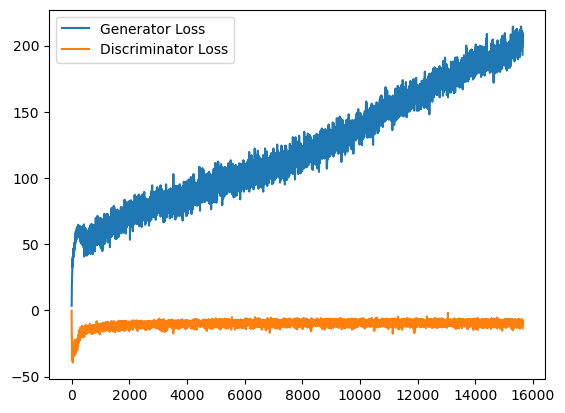

In [5]:
plt.figure()
plt.plot(generator_loss_values, label="Generator Loss")
plt.plot(discriminator_loss_values, label="Discriminator Loss")
plt.legend()
plt.show()


In [2]:
if not os.path.exists('Results/FID_score'):
       os.makedirs('Results/FID_score')
np.save('Results/FID_score/WGANGP_FID', frechet_distances) 